### In this notebook we will compile interesting questions that we can answer using the data from this table.
### We can refer to data_exploration.ipynb to figure out what kind of information we already have.

1. On an average, how often do people order from Instacart?
2. What product was ordered most often?
3. At what time during the day do people order most? Can we have a plot for how busy different times during the day are?
4. How often do people order ice-cream? How often do they order alcohol?
5. If we classify all food-related orders under food groups (dairy, vegetables, protein) - what groups are represented more than others in terms of number of items?
6.  What is usually the first item people put into their cart?

### Q1. On an average, how often do people order from Instacart?

In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import math

import seaborn as sns
color = sns.color_palette()
%matplotlib inline

In [23]:
orders = pd.read_csv('/orders.csv')#./instacart-market-basket-analysis/orders.csv
department = pd.read_csv('/departments.csv') #./instacart-market-basket-analysis/departments.csv
order_products_prior = pd.read_csv('/order_products__prior.csv')#./instacart-market-basket-analysis/order_products__prior.csv
products = pd.read_csv('/products.csv')#./instacart-market-basket-analysis/products.csv

In [24]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [25]:
# plan: take the average of the row days_since_prior_order, but don't include NaNs.
# pandas ignores NaNs while taking average, so we only need to call the average method on the series.

print('On an average, people order once every ', orders['days_since_prior_order'].mean(), 'days')

On an average, people order once every  11.114836226863012 days


### Q2. What product was ordered most often?

In [26]:
# plan - we use two tables: order_products__train.csv and order_products__prior.csv. We assume these have different values, and we check if they are the same. Best to check the kaggle dataset for any hints as to what these files have.

# for simplicity, we take just one file for this question - prior.


In [27]:
# the table looks like so:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1.0
1,2,28985,2,1.0
2,2,9327,3,0.0
3,2,45918,4,1.0
4,2,30035,5,0.0
...,...,...,...,...
20995336,2214666,45763,8,1.0
20995337,2214666,25466,9,1.0
20995338,2214666,47759,10,1.0
20995339,2214666,31354,11,0.0


In [28]:
# for each order, we want each product to be considered only once in our calculations. So we should remove duplicates of the same order_id and product_id for this question.

df = order_products_prior.drop_duplicates(subset=['order_id', 'product_id'])

df_with_product_description = df.merge(products, on = 'product_id', how='inner')

In [29]:
df_with_product_description

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1.0,Organic Egg Whites,86,16
1,26,33120,5,0.0,Organic Egg Whites,86,16
2,120,33120,13,0.0,Organic Egg Whites,86,16
3,327,33120,5,1.0,Organic Egg Whites,86,16
4,390,33120,28,1.0,Organic Egg Whites,86,16
...,...,...,...,...,...,...,...
20995336,2184501,4417,14,0.0,Organic Veggie Ground,14,20
20995337,2187851,16979,2,0.0,Zero Mercury 2025 Lithium Batteries,87,17
20995338,2196056,14128,3,0.0,Tangerine Melon Bubble Bath,25,11
20995339,2199666,25131,1,0.0,All Natural Dill Weed,104,13


In [30]:
# now if we group by product_id and show count along with product_id, that should be quite interesting
# but product_id tells us nothing, so best to also join the result to products table.
df_with_product_description.groupby(['product_name']).count().sort_values(by = 'order_id', ascending=False)['order_id']

product_name
Banana                              306688
Bag of Organic Bananas              245484
Organic Strawberries                171504
Organic Baby Spinach                156296
Organic Hass Avocado                138105
                                     ...  
Disinfecting Toilet Bowl Cleaner         1
Unflavored Arctic Cod Liver Oil          1
Sweet Echinacea                          1
18 Year Scotch Whisky                    1
Marmalade, Pink Grapefruit               1
Name: order_id, Length: 49543, dtype: int64

In [31]:
print('Bananas were ordered most often, followed Strawberries, Baby Spinach, and Avocados')

Bananas were ordered most often, followed Strawberries, Baby Spinach, and Avocados


### Q3. At what time during the day do people order most often?

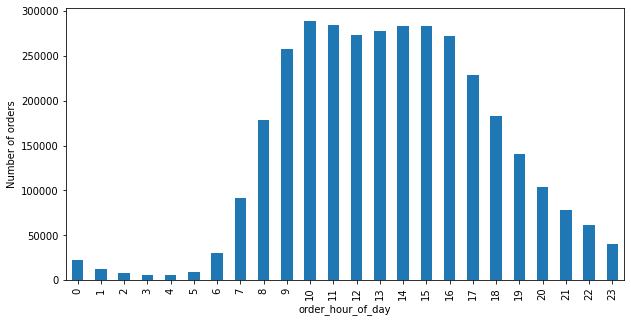

In [32]:
# plan - take orders table and group by order time of day
time_of_day = orders.groupby(by='order_hour_of_day').count().sort_values(by='order_hour_of_day', ascending=True)
plt.figure(figsize=(10,5))
time_of_day['order_id'].plot.bar()
plt.ylabel('Number of orders');

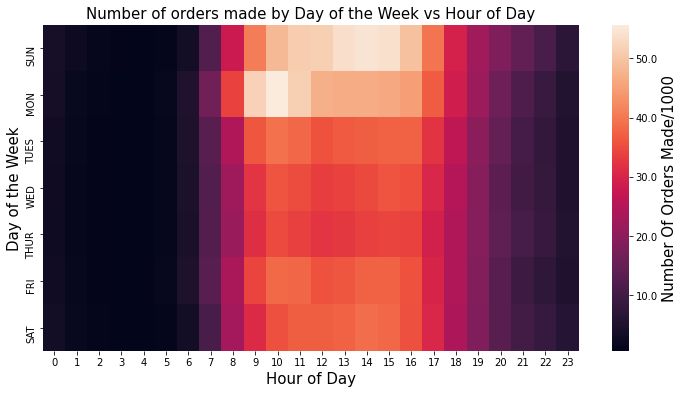

In [33]:
grouped_data = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_data = grouped_data.pivot('order_dow', 'order_hour_of_day', 'order_number')

grouped_data.index = pd.CategoricalIndex(grouped_data.index, categories=[0,1,2,3,4,5,6])
grouped_data.sort_index(level=0, inplace=True)

plt.figure(figsize=(12,6))
hour_of_day = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14','15','16', '17', '18', '19','20', '21', '22', '23']
dow = [ 'SUN', 'MON', 'TUES', 'WED', 'THUR','FRI','SAT']  

ax = sns.heatmap(grouped_data, xticklabels=hour_of_day,yticklabels=dow,cbar_kws={'label': 'Number Of Orders Made/1000'})
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 10000, 20000, 30000, 40000, 50000])
cbar.set_ticklabels(['0','10.0','20.0','30.0','40.0','50.0'])
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[0].yaxis.label.set_size(15)
ax.figure.axes[0].xaxis.label.set_size(15)

ax.set(xlabel='Hour of Day', ylabel= "Day of the Week")
ax.set_title("Number of orders made by Day of the Week vs Hour of Day", fontsize=15)
plt.show()

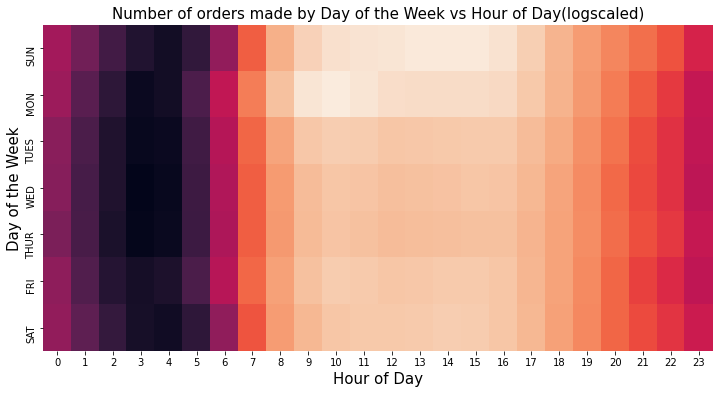

In [34]:
grouped_data = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_data = grouped_data.pivot('order_dow', 'order_hour_of_day', 'order_number')

grouped_data.index = pd.CategoricalIndex(grouped_data.index, categories=[0,1,2,3,4,5,6])
grouped_data.sort_index(level=0, inplace=True)

plt.figure(figsize=(12,6))
hour_of_day = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14','15','16', '17', '18', '19','20', '21', '22', '23']
dow = [ 'SUN', 'MON', 'TUES', 'WED', 'THUR','FRI','SAT']  

ax = sns.heatmap(grouped_data, xticklabels=hour_of_day,yticklabels=dow,norm=LogNorm(),cbar=False)
cbar = ax.collections[0].colorbar

ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[0].yaxis.label.set_size(15)
ax.figure.axes[0].xaxis.label.set_size(15)


ax.set(xlabel='Hour of Day', ylabel= "Day of the Week")
ax.set_title("Number of orders made by Day of the Week vs Hour of Day(logscaled)", fontsize=15)
plt.show()

### Q4. What departments are the most popular? What can we say about food habits based on this?

In [35]:
# plan: Which departments are most popular?
# which departments have the most products ordered from them.
# from order product table, group by department. Merge with department table.


In [36]:
df_with_product_description_dept = df_with_product_description.merge(department, on='department_id') # contains all the info for this question

In [37]:
df_with_product_description_dept

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,33120,1,1.0,Organic Egg Whites,86,16,dairy eggs
1,26,33120,5,0.0,Organic Egg Whites,86,16,dairy eggs
2,120,33120,13,0.0,Organic Egg Whites,86,16,dairy eggs
3,327,33120,5,1.0,Organic Egg Whites,86,16,dairy eggs
4,390,33120,28,1.0,Organic Egg Whites,86,16,dairy eggs
...,...,...,...,...,...,...,...,...
20995336,2060183,27047,34,0.0,Bloody Mary Cocktail Mix,6,2,other
20995337,1682445,19869,1,0.0,Sniffle Support Drops Alcohol Free Formula,6,2,other
20995338,1948556,19869,5,0.0,Sniffle Support Drops Alcohol Free Formula,6,2,other
20995339,1884444,13103,16,0.0,Boneless Beef Top Round Steak,6,2,other


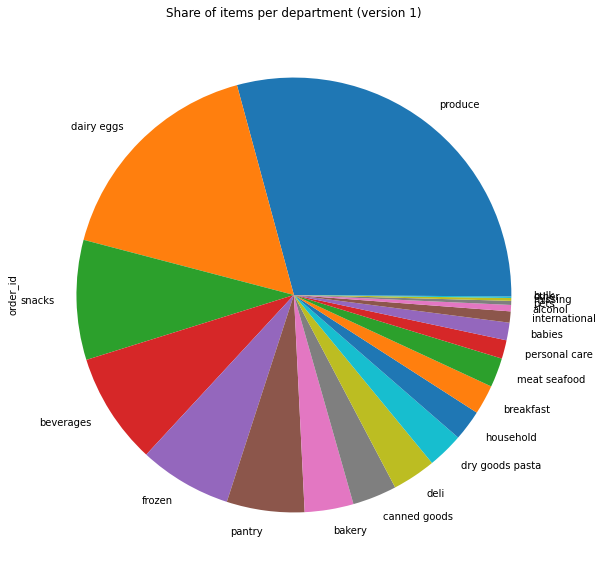

In [38]:
how_many_items_per_department = df_with_product_description_dept.groupby(by='department').count()['order_id'].sort_values(ascending = False)
how_many_items_per_department.plot.pie(y='order_id', figsize = [10,10], title = 'Share of items per department (version 1)');

## Q6. What is usually the first item that shoppers put into their carts?

### filter the dataset such that you only have those orders which satisfy add_to_cart_order == 1

In [39]:
first_in_cart = df_with_product_description['add_to_cart_order'] == 1

In [40]:
first_in_cart_products = df_with_product_description[first_in_cart]

In [41]:
first_in_cart_products.groupby(by='product_name').count()['order_id'].sort_values(ascending = False)[:15]

product_name
Banana                        71884
Bag of Organic Bananas        51109
Organic Whole Milk            20131
Organic Strawberries          18195
Organic Hass Avocado          15587
Organic Baby Spinach          15191
Organic Avocado               14418
Spring Water                  10802
Strawberries                  10579
Organic Raspberries            9149
Sparkling Water Grapefruit     8905
Organic Half & Half            8195
Large Lemon                    8010
Soda                           7544
Organic Reduced Fat Milk       6460
Name: order_id, dtype: int64

The first thing people put in their carts is generally produce.
Why do people order produce so often? Because it is perishable. You buy it in small quantities, because if you buy too much at one time, it goes bad. Another reason is that it is genuinely popular. Fruits make great snacks!